In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import (precision_score, recall_score,
                             precision_recall_curve,f1_score, 
                             fbeta_score, confusion_matrix)


from splits import split_users # contains split_users func

pd.set_option("display.max_columns", 101)
pd.set_option("display.max_rows", 100)

In [2]:
# read in pickled feature DF generated by feature_engineering_3.ipynb
X = pd.read_pickle("./pickle/X_25.pickle")

In [3]:
X['streak'] = X['streak'].astype(float)

In [4]:
X_train, X_test, y_train, y_test = split_users(X, subset=False, test_size=0.2)


    X_train sample size: 6782401
    X_test sample size: 1692260


In [5]:
# y_train = ~(y_train.astype(bool))
# y_test = ~(y_test.astype(bool))

In [6]:
~y_train[:5]

0   -1
1   -1
2   -1
3   -1
4   -1
Name: in_cart, dtype: int64

In [7]:
with open(f"models/xgboost_fit_all.pickle", "rb") as pfile:
        xgb_fit = pickle.load(pfile)

In [8]:
xgb_fit.score(X_test, y_test)

0.9100079184049732

# Determining the Optimal Probability Threshold

What will Instacart use this model for?

This is an important question to consider at every stage, especially when determining our probability threshold. We can adjust the threshold meter in the below confusion matrix to determine the optimal probability threshold our model uses to classify inputs. A higher threshold means the model will be less likely to classify an input as a 'reorder'. A lower threshold results in more `1` predictions. If our model were a person, the person would *need less convincing* to predict `1` with a *lower threshold*.

**So...what does that mean for our Instacart dataset?**

Instacart uses the model's predictions for two use-cases (per their [blog post](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)):
1. "Buy it Again?" user prompts
2. "Frequently bought with..." user prompt when shopping


In both cases, the 'risk' of making false reorder predictions seems pretty low (if any). In practice, this means to prioritize **recall** (`predicted positives / all positives`) & reduce false negatives as much as possible. We'll intentionally be inflating our false positives (incorrectly predicting an item as a reorder in the user's next cart). Doing this should benefit Instacart, as highlighting these items to the user may increase conversion.

In summary, **our goal is find a low enough probability threshold in which items that the user *might* purchase are captured, while still correctly classifying products the user is very unlikely to purchase.**

Let's try and find a reasonable probability threshold using the below slider & confusion matrix.

In [9]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    instacart_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(instacart_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['not_reordered', 'reordered'],
           yticklabels=['not_reordered', 'reordered']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [49]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    
    confusion = confusion_matrix(y_test, y_predict)
    
    plt.figure(dpi=80, figsize=(9, 9))
    
    group_counts = ["{0:0.0f}".format(value) for value in confusion.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in confusion.flatten()/np.sum(confusion)]
    labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    label_font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 30,
        }
    
    sns.heatmap(confusion, annot=labels, fmt="", cmap="Blues",
                xticklabels=['not_reordered', 'reordered'],
                yticklabels=['not_reordered', 'reordered']);
    plt.xlabel('prediction', fontdict=label_font)
    plt.ylabel('actual', fontdict=label_font)

In [50]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(xgb_fit, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [29]:
threshold = 0.14

y_predict = (xgb_fit.predict_proba(X_test)[:, 1] >= threshold)
    
confusion = confusion_matrix(y_test, y_predict)

Text(40.999999999999986, 0.5, 'actual')

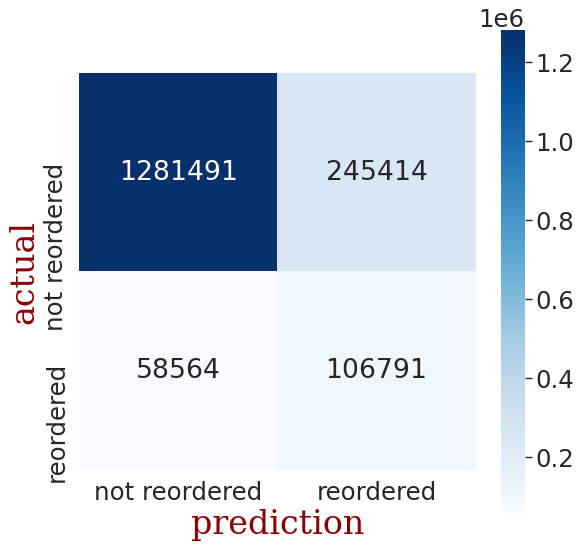

In [30]:

sns.set(font_scale=2)

label_font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 30,
        }

plt.figure(dpi=80, figsize=(8, 8))
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
            xticklabels=['not reordered', 'reordered'],
            yticklabels=['not reordered', 'reordered']);
plt.xlabel('prediction', fontdict=label_font)
plt.ylabel('actual', fontdict=label_font)

<AxesSubplot:>

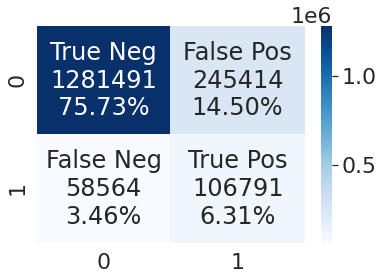

In [31]:
group_counts = ["{0:0.0f}".format(value) for value in confusion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in confusion.flatten()/np.sum(confusion)]
labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion, annot=labels, fmt="", cmap="Blues")

Best threshold: 0.14

So what's our new precision and F1 metrics, using this threshold?

**Precision = TruePositives / (TruePositives + FalsePositives)**

**Recall = TruePositives / (TruePositives + FalseNegatives)**

In [32]:
confusion

array([[1281491,  245414],
       [  58564,  106791]])

In [33]:
true_pos = confusion[1][1]
true_neg = confusion[0][0]

false_pos = confusion[0][1]
false_neg = confusion[1][0]

In [34]:
precision = true_pos / (true_pos + false_pos)

precision

0.30320693914055735

In [35]:
recall = true_pos / (true_pos + false_neg)

recall

0.6458286716458529

And now...our adjusted F-1 score

F-1 = (2 * Precision * Recall) / (Precision + Recall)

In [36]:
f1 = (2 * precision * recall) / (precision + recall)

f1

0.412670994667285

In [37]:
def get_threshold_f1s(model, min_threshold=0.01, max_threshold=1.0):
    
    thresholds = {}
    
    for threshold in np.arange(min_threshold, max_threshold, 0.01):
        print(f"Starting threshold {threshold*100}%...")
        
        # create confusion matrix
        y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
        confusion = make_confusion_matrix(y_test, y_predict)
        
        # extract values needed for precision/recall/f-1 calculations
        true_pos = confusion[1][1]
        false_pos = confusion[0][1]
        false_neg = confusion[1][0]
        
        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)
        f1 = (2 * precision * recall) / (precision + recall)
        thresholds[threshold] = f1
        
        print(f"End calculating {threshold*100}%. Result: {f1:.2f}")
    
    return thresholds

thresholds = get_threshold_f1s(xgb_fit)


Starting threshold 1.0%...
End calculating 1.0%. Result: 0.18
Starting threshold 2.0%...
End calculating 2.0%. Result: 0.19
Starting threshold 3.0%...
End calculating 3.0%. Result: 0.22
Starting threshold 4.0%...
End calculating 4.0%. Result: 0.26
Starting threshold 5.0%...
End calculating 5.0%. Result: 0.28
Starting threshold 6.000000000000001%...
End calculating 6.000000000000001%. Result: 0.30
Starting threshold 6.999999999999999%...
End calculating 6.999999999999999%. Result: 0.32
Starting threshold 8.0%...
End calculating 8.0%. Result: 0.34
Starting threshold 9.0%...
End calculating 9.0%. Result: 0.36
Starting threshold 10.0%...
End calculating 10.0%. Result: 0.37
Starting threshold 11.0%...
End calculating 11.0%. Result: 0.38
Starting threshold 12.0%...
End calculating 12.0%. Result: 0.39
Starting threshold 13.0%...
End calculating 13.0%. Result: 0.40
Starting threshold 14.000000000000002%...
End calculating 14.000000000000002%. Result: 0.41
Starting threshold 15.000000000000002%

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


End calculating 90.0%. Result: nan
Starting threshold 91.0%...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


End calculating 91.0%. Result: nan
Starting threshold 92.0%...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


End calculating 92.0%. Result: nan
Starting threshold 93.0%...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


End calculating 93.0%. Result: nan
Starting threshold 94.0%...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


End calculating 94.0%. Result: nan
Starting threshold 95.0%...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


End calculating 95.0%. Result: nan
Starting threshold 96.00000000000001%...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


End calculating 96.00000000000001%. Result: nan
Starting threshold 97.0%...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


End calculating 97.0%. Result: nan
Starting threshold 98.0%...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


End calculating 98.0%. Result: nan
Starting threshold 99.0%...
End calculating 99.0%. Result: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [39]:
def pull_max_f1(f1_thresholds):
    """
    Parameters
    _____
    f1_thresholds(dict, required): Mapping, like {probability_threshold: f1_score}
    
    Returns:
    _____
    String containing the threshold parameter resulting in the highest F-1 score.
    """
    # pull the threshold with the highest f-1 score
    max_f1 = (0, 0)
    for thresh, f1 in thresholds.items():
        
        if f1 > max_f1[1]:
            max_f1 = thresh, f1
        continue
    
    return print(f"Best threshold: {max_f1[0]}\n Resulting F-1 score: {max_f1[1]}")
        
        
pull_max_f1(thresholds)

Best threshold: 0.22
 Resulting F-1 score: 0.43928231939163503


In [46]:
def get_thresholds_recall(model, min_threshold=0.01, max_threshold=1.0):
    
    t = {}
    
    for threshold in np.arange(min_threshold, max_threshold, 0.01):
        print(f"Starting threshold {threshold*100}%...")
        
        # create confusion matrix
        y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
        confusion = confusion_matrix(y_test, y_predict)
        
        # extract values needed for precision/recall/f-1 calculations
        true_pos = confusion[1][1]
        false_neg = confusion[1][0]
        
        recall = true_pos / (true_pos + false_neg)
        t[threshold] = recall
        
        print(f"End calculating {threshold*100}%. Result (recall): {recall:.2f}")
    
    return t

recall_thresholds = get_thresholds_recall(xgb_fit, min_threshold=0.05, max_threshold=0.5)

Starting threshold 5.0%...
End calculating 5.0%. Result (recall): 0.90
Starting threshold 6.000000000000001%...
End calculating 6.000000000000001%. Result (recall): 0.87
Starting threshold 7.000000000000001%...
End calculating 7.000000000000001%. Result (recall): 0.84
Starting threshold 8.000000000000002%...
End calculating 8.000000000000002%. Result (recall): 0.81
Starting threshold 9.000000000000002%...
End calculating 9.000000000000002%. Result (recall): 0.78
Starting threshold 10.0%...
End calculating 10.0%. Result (recall): 0.75
Starting threshold 11.000000000000002%...
End calculating 11.000000000000002%. Result (recall): 0.72
Starting threshold 12.000000000000002%...
End calculating 12.000000000000002%. Result (recall): 0.70
Starting threshold 13.0%...
End calculating 13.0%. Result (recall): 0.67
Starting threshold 14.000000000000002%...
End calculating 14.000000000000002%. Result (recall): 0.65
Starting threshold 15.000000000000002%...
End calculating 15.000000000000002%. Resul

KeyboardInterrupt: 

In [ ]:
def pull_max_recall(recall_thresholds):
    """
    Parameters
    _____
    recall_thresholds(dict, required): Mapping, like {probability_threshold: recall_score}
    
    Returns:
    _____
    String containing the threshold parameter resulting in the highest recall score.
    """
    # pull the threshold with the highest recall
    max_recall = (0, 0)
    for thresh, recall in thresholds.items():
        
        if recall > max_recall[1]:
            max_recall = thresh, recall
        continue
    
    return print(f"Best threshold: {max_recall[0]}\n Resulting Recall score: {max_recall[1]}")
        
        
pull_max_recall(recall_thresholds)

In [ ]:
preds = xgb_fit.predict(X_test)

In [ ]:
preds_praba = xgb_fit.predict_proba(X_test)

In [ ]:
f1_score(y_test, preds)

In [ ]:
precision_score(y_test, preds)

In [ ]:
recall_score(y_test, preds)

# Precision/Recall

In [ ]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, preds)

In [ ]:
plt.figure()
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [ ]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");